In [9]:
# requirements:
# pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn shap fastapi uvicorn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import shap
import json


(200, 20)
Tourist_ID                    object
Trip_Start_Time               object
Trip_End_Time                 object
Current_Location              object
Previous_Location             object
Expected_Location             object
Timestamp                     object
Safety_Score                   int64
Zone_Type                     object
Geo_Fence_Alert               object
Panic_Button_Activated        object
Emergency_Contact_Notified    object
Activity_Status               object
Inactivity_Duration            int64
Route_Deviation_Flag          object
Health_Status                 object
Language_Preference           object
Family_Tracking_Opted         object
Alert_Type                    object
Anomaly_Flag                  object
dtype: object


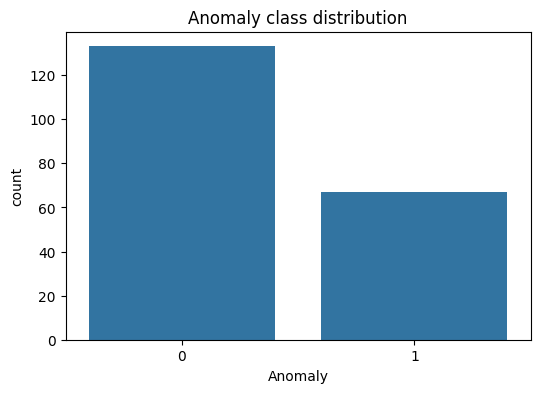

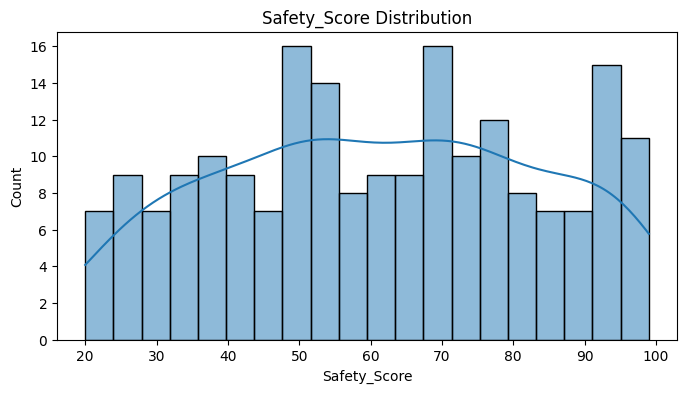

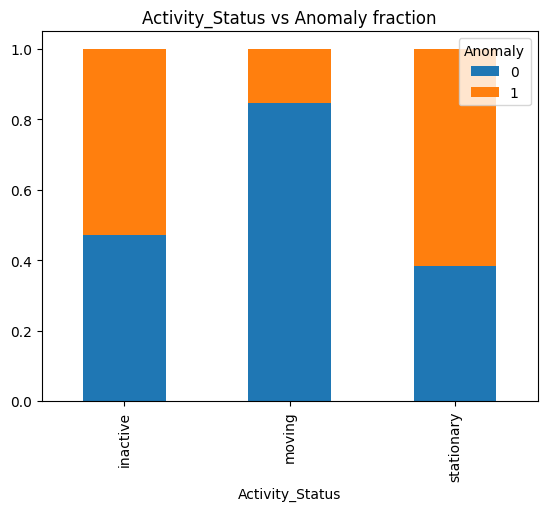

In [10]:
df = pd.read_csv('/content/tourist_anomaly_dummy_dataset_final.csv')

# quick peek
print(df.shape)
print(df.dtypes)
df.head()

# Convert label to binary
df['Anomaly'] = df['Anomaly_Flag'].map({'yes':1, 'no':0})

# Convert datetimes
for col in ['Trip_Start_Time', 'Trip_End_Time', 'Timestamp']:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%dT%H:%M:%S")

# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='Anomaly', data=df)
plt.title('Anomaly class distribution')
plt.show()

# Safety score distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Safety_Score'], kde=True, bins=20)
plt.title('Safety_Score Distribution')
plt.show()

# Activity status vs anomaly
pd.crosstab(df['Activity_Status'], df['Anomaly'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Activity_Status vs Anomaly fraction')
plt.show()


In [11]:
# helper: parse "lat,lon" -> floats
def split_latlon(s):
    try:
        lat, lon = s.split(',')
        return float(lat), float(lon)
    except:
        return np.nan, np.nan

df[['cur_lat','cur_lon']] = df['Current_Location'].apply(lambda s: pd.Series(split_latlon(s)))
df[['exp_lat','exp_lon']] = df['Expected_Location'].apply(lambda s: pd.Series(split_latlon(s)))
df[['prev_lat','prev_lon']] = df['Previous_Location'].apply(lambda s: pd.Series(split_latlon(s)))

# haversine
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2-lat1)
    dlambda = np.radians(lon2-lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_to_expected_km'] = haversine_np(df['cur_lat'], df['cur_lon'], df['exp_lat'], df['exp_lon'])
df['dist_prev_cur_km'] = haversine_np(df['prev_lat'], df['prev_lon'], df['cur_lat'], df['cur_lon'])

# time based features
df['trip_duration_hours'] = (df['Trip_End_Time'] - df['Trip_Start_Time']).dt.total_seconds()/3600.0
df['hour'] = df['Timestamp'].dt.hour
df['is_night'] = df['hour'].apply(lambda h: 1 if (h<6 or h>20) else 0)
df['dayofweek'] = df['Timestamp'].dt.dayofweek

# Basic speed estimate (km per hour) if prev timestamp available - we don't have prev timestamp, so approximate:
# speed = dist_prev_cur_km / (delta_time_hours) - if no delta_time, leave as 0
df['est_speed_kmph'] = df['dist_prev_cur_km'] / (df['trip_duration_hours'].replace(0, np.nan))
df['est_speed_kmph'] = df['est_speed_kmph'].fillna(0)


In [13]:
# Candidate features
num_features = ['Safety_Score', 'Inactivity_Duration', 'dist_to_expected_km', 'dist_prev_cur_km',
                'trip_duration_hours', 'est_speed_kmph', 'hour', 'dayofweek', 'is_night']
cat_features = ['Zone_Type', 'Geo_Fence_Alert', 'Panic_Button_Activated', 'Route_Deviation_Flag',
                'Health_Status', 'Activity_Status', 'Family_Tracking_Opted', 'Language_Preference']

# Clean some categorical values
for c in cat_features:
    df[c] = df[c].fillna('unknown').astype(str)

# Create preprocessing transformer
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric transformer
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical transformer (updated for sklearn >=1.2)
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


In [15]:
X = df[num_features + cat_features]
y = df['Anomaly']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("train", X_train.shape, "val", X_val.shape, "test", X_test.shape)


train (140, 17) val (30, 17) test (30, 17)


In [16]:
print("Anomaly rate in train:", y_train.mean())

# Option A: Use SMOTE to oversample minority class after encoding
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)


Anomaly rate in train: 0.3357142857142857


In [17]:
# RandomForest on preprocessed data
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Evaluate on val
y_val_pred_proba = rf.predict_proba(X_val_enc)[:,1]
y_val_pred = rf.predict(X_val_enc)

print("ROC AUC:", roc_auc_score(y_val, y_val_pred_proba))
print("PR AUC (Average precision):", average_precision_score(y_val, y_val_pred_proba))
print(classification_report(y_val, y_val_pred))
print("Confusion:\n", confusion_matrix(y_val, y_val_pred))


ROC AUC: 1.0
PR AUC (Average precision): 0.9999999999999999
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.92      0.95      0.93        30
weighted avg       0.94      0.93      0.93        30

Confusion:
 [[18  2]
 [ 0 10]]


In [18]:
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}
rs = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                        param_distributions=param_dist,
                        n_iter=20, scoring='average_precision', cv=3, verbose=2, n_jobs=-1, random_state=42)
rs.fit(X_train_res, y_train_res)
print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [19]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train_enc)
scores = -iso.decision_function(X_val_enc)  # higher = more anomalous
print("PR AUC (iso)", average_precision_score(y_val, scores))


PR AUC (iso) 0.48968188266916224


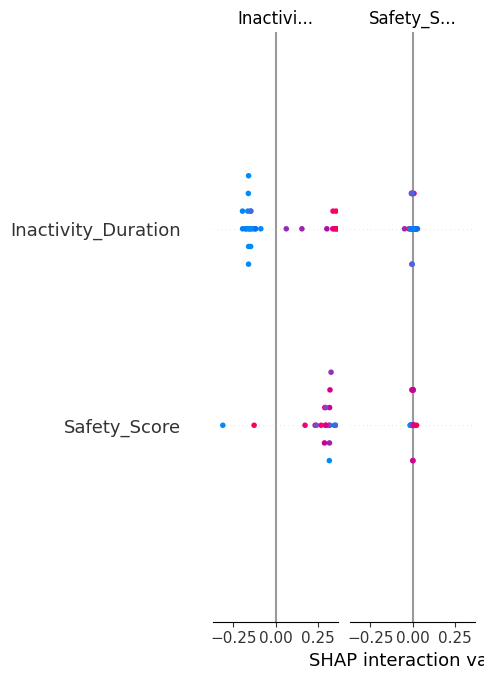

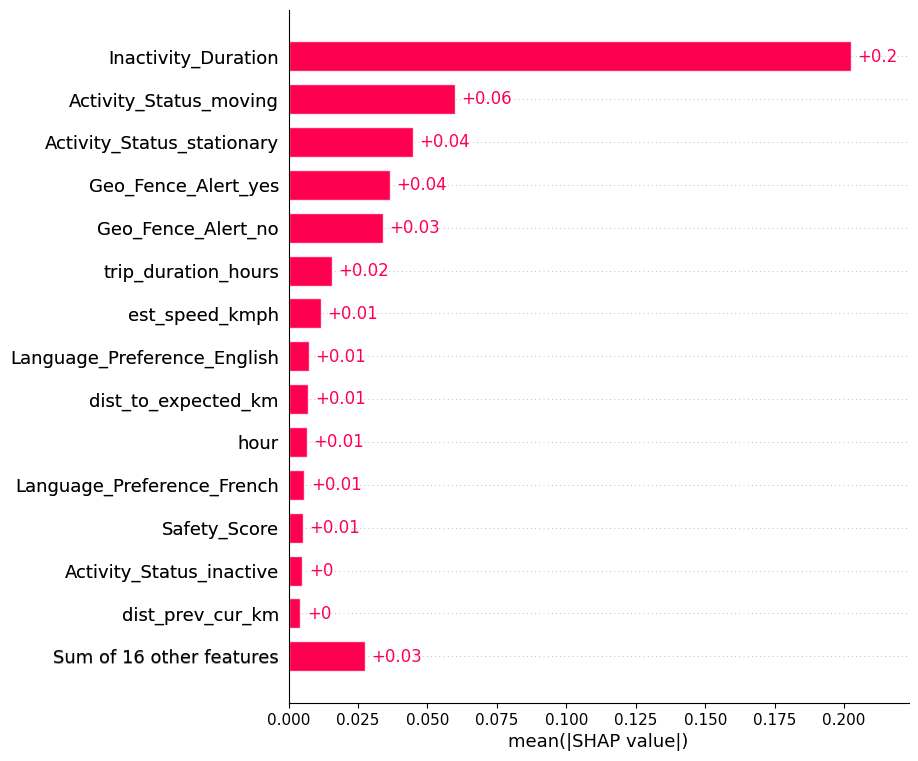

In [26]:
import shap
import pandas as pd
from sklearn.pipeline import Pipeline

# 1. Combine preprocessor + classifier into pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])

# Fit pipeline
full_pipeline.fit(X_train, y_train)

# 2. Transform validation data
X_val_transformed = full_pipeline.named_steps['preprocessor'].transform(X_val)

# 3. Get feature names (numeric + one-hot encoded)
num_names = num_features
cat_names = full_pipeline.named_steps['preprocessor'] \
                        .named_transformers_['cat'] \
                        .named_steps['ohe'] \
                        .get_feature_names_out(cat_features).tolist()

feature_names = num_names + cat_names

# Wrap into DataFrame
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=feature_names)

# 4. Build SHAP explainer (new API)
explainer = shap.Explainer(full_pipeline.named_steps['classifier'], X_val_transformed_df)
shap_values = explainer(X_val_transformed_df)

# -------------------
# ✅ Global feature importance
# -------------------
# Beeswarm summary plot
shap.summary_plot(shap_values, X_val_transformed_df)

# Bar plot (pick single output for binary classification)
shap.plots.bar(shap_values[:, :, 1], max_display=15)  # class=1 → anomaly
# -------------------

# -------------------
# ✅ Local explanation for one tourist
# -------------------
shap.initjs()
sample_idx = 0  # first record
shap.force_plot(
    explainer.expected_value[1],                 # baseline for anomaly class
    shap_values[sample_idx, :, 1].values,        # SHAP values for sample, anomaly class
    X_val_transformed_df.iloc[sample_idx, :]     # feature values
)


In [27]:
X_test_enc = preprocessor.transform(X_test)
y_test_proba = best_rf.predict_proba(X_test_enc)[:,1]

print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("Test PR AUC:", average_precision_score(y_test, y_test_proba))

# choose threshold for desired precision-recall tradeoff (e.g., target 0.6 precision)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
# find threshold for precision >= 0.6
idx = np.where(precision >= 0.6)[0]
if idx.size>0:
    chosen_thresh = thresholds[idx[0]]
else:
    chosen_thresh = 0.5
print("Chosen threshold:", chosen_thresh)
y_test_pred_thresh = (y_test_proba >= chosen_thresh).astype(int)
print(classification_report(y_test, y_test_pred_thresh))


Test ROC AUC: 0.9800000000000001
Test PR AUC: 0.9572979797979797
Chosen threshold: 0.1825
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.62      1.00      0.77        10

    accuracy                           0.80        30
   macro avg       0.81      0.85      0.80        30
weighted avg       0.88      0.80      0.81        30



In [28]:
# Save both preprocessor and model together as a pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])
full_pipeline.fit(X_train, y_train)  # fit on original train (no SMOTE) or optionally on resampled encoded data depending on approach

joblib.dump(full_pipeline, 'tourist_anomaly_pipeline_v1.joblib')


['tourist_anomaly_pipeline_v1.joblib']

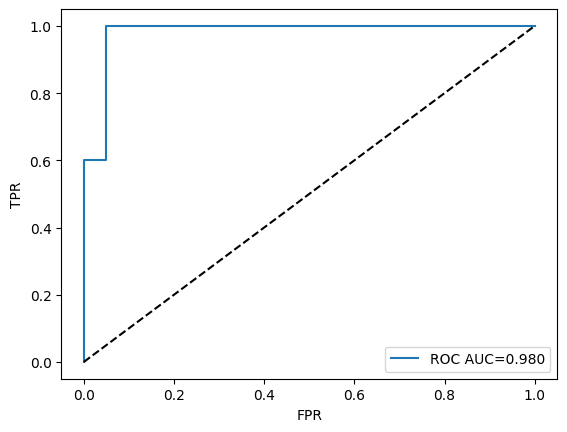

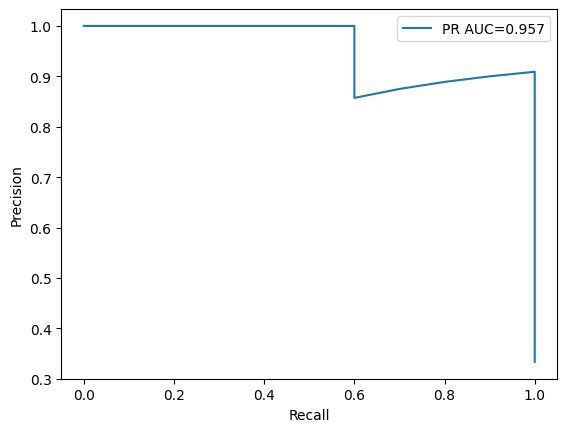

In [29]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
pr, rc, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_score(y_test, y_test_proba):.3f}"); plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.figure(); plt.plot(rc, pr, label=f"PR AUC={average_precision_score(y_test, y_test_proba):.3f}"); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()
plt.show()
